# OLS on time-aware smoothed ratings

# Importing libraries and data

In [2]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import scipy
import psycopg2
con = psycopg2.connect(database='codeforces', user='Joy')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['figure.facecolor'] = 'white'


this file still contains the Savitzky–Golay filter on ratings, but it has other information we need

drop the smooth rating columns and add the time aware ones

In [173]:
train = pd.read_csv('training_linear_regression_smooth.csv', engine='c')
train.dropna(inplace=True, axis=0)

smoothed_ratings = pd.read_csv('user_ratings_smoothed.csv', engine='c')

In [174]:
# calculate difference
gusr = smoothed_ratings.groupby('handle')
stack = []

for usr, dfu in gusr:
    dfu.is_copy=False
    dfu.sort_values('ratingupdatetimeseconds', inplace=True)
    stack.append(dfu)

df_smooth = pd.concat(stack)
for month in range(1, 6):
    curr = df_smooth["smoothed_%dmonths" % month]
    prev = np.roll(curr, 1)

    delta = curr - prev
    df_smooth["delta_smoothed_%dmonths" % month] = delta

In [175]:
dfm = pd.merge(train, df_smooth, on=['handle', 'contestid'])

In [177]:
print dfm.shape
dfm.head()

(627996, 71)


,*special,2-sat,binary search,bitmasks,brute force,chinese remainder theorem,combinatorics,constructive algorithms,contestid,contesttime,...,smoothed_1months,smoothed_2months,smoothed_3months,smoothed_4months,smoothed_5months,delta_smoothed_1months,delta_smoothed_2months,delta_smoothed_3months,delta_smoothed_4months,delta_smoothed_5months
0,0,0,0,1,0,0,0,1,10,1271346469,...,1821.000000,1748.00,1748.000000,1748.000000,1748.000000,57.000000,65.00,65.000000,65.000000,65.000000
1,0,0,0,0,1,0,0,0,101,1312391097,...,2609.500000,2624.25,2596.000000,2570.909091,2564.250000,-18.500000,4.65,13.500000,3.809091,21.557692
2,0,0,0,0,1,0,0,0,105,1313248099,...,2607.666667,2617.25,2615.857143,2587.300000,2573.666667,-1.833333,-7.00,19.857143,16.390909,9.416667
3,0,0,0,0,0,0,0,0,107,1314112086,...,2608.666667,2609.00,2619.000000,2598.500000,2576.692308,1.000000,-8.25,3.142857,11.200000,3.025641
4,0,0,0,0,0,0,0,0,109,1314633737,...,2606.750000,2607.40,2616.428571,2598.727273,2578.428571,-1.916667,-1.60,-2.571429,0.227273,1.736264


In [205]:
X = dfm.drop(['contesttime', 'contestid', 'handle'], axis=1)
X.reset_index()

month = 3
Y = X['delta_smoothed_%dmonths'%month]
for i in range(1, 6):
    X.drop('delta_smoothed_%dmonths' % i, axis = 1, inplace=True)
    
X['bias'] = 1

# Null model

In [103]:
# null model

ss_tot = np.var(Y) * len(Y)

ybar = np.mean(Y)
ss_tot = np.sum((Y-ybar)**2)
ss_res = np.sum((Y - 0)**2)

1 - ss_res / ss_tot

-0.053723831804432631

In [104]:
# fit a horizontal line
results = sm.OLS(Y, [1]*len(Y)).fit()
print results.summary()

                              OLS Regression Results                              
Dep. Variable:     delta_smoothed_3months   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                  0.000
Method:                     Least Squares   F-statistic:                       inf
Date:                    Wed, 07 Jun 2017   Prob (F-statistic):                nan
Time:                            13:57:20   Log-Likelihood:            -2.2365e+06
No. Observations:                  465028   AIC:                         4.473e+06
Df Residuals:                      465027   BIC:                         4.473e+06
Df Model:                               0                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

/usr/local/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


# First order model

In [182]:
X.columns

Index([u'*special', u'2-sat', u'binary search', u'bitmasks', u'brute force',
       u'chinese remainder theorem', u'combinatorics',
       u'constructive algorithms', u'data structures', u'dfs and similar',
       u'divide and conquer', u'dp', u'dsu', u'expression parsing', u'fft',
       u'flows', u'games', u'geometry', u'graph matchings', u'graphs',
       u'greedy', u'hashing', u'implementation', u'math', u'matrices',
       u'meet-in-the-middle', u'n_contest', u'n_harder', u'n_harder100',
       u'n_harder50', u'n_harder500', u'n_wrong_mean', u'n_wrong_std',
       u'number theory', u'probabilities', u'problems_solved',
       u'rating_change', u'rating_change_smooth', u'rating_diff_mean',
       u'rating_diff_std', u'schedules', u'shortest paths', u'sortings',
       u'string suffix structures', u'strings', u'ternary search',
       u'time_between_mean', u'time_between_std', u'trees', u'two pointers',
       u'user_rating', u'user_rating_smooth', u'time', u'contestname',
       u'

In [206]:
cols = ['rating_diff_mean', 'n_harder', 'n_wrong_mean', 'rating_diff_std', 'n_contest', 'smoothed_%dmonths'%month]

results_rating_only = sm.OLS(Y.values, X['smoothed_%dmonths'%month]).fit()
print "ratings only:", results_rating_only.rsquared

results = sm.OLS(Y.values, X[cols]).fit()
print "all params  :", results.rsquared
#
##print X[cols].head(), Y.head()

ratings only: 0.0137455882731
all params  : 0.0305874712283


In [207]:
lows = [0   , 1100, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1700, 1800, 1900, 2000, 2100]
highs= [1100, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1700, 1800, 1900, 2000, 2100, 2500]

contr_all = []
contr_rating = []
contr_norating = []

colname = 'smoothed_%dmonths' % month

for low, high in zip(lows, highs):
    X = dfm.drop(['contesttime', 'contestid'], axis=1)

    # drop users who are tanking on purpose
    drop_users = set(['Hedgehogy', 'errorerror', 'Mhammad1', 'NelsonMondialu'])
    X.is_copy = False
    X.drop(X.index[X.handle.apply(lambda x: x in drop_users)], inplace=True)

    X = X.loc[np.logical_and(X[colname] >= low, X[colname] <= high)]

    # select features to use
    Y = X['delta_smoothed_%dmonths' % month]
    X = X[cols]

    results_rating_only = sm.OLS(Y.values, X[colname]).fit()
    results = sm.OLS(Y.values, X).fit()
    X.drop(colname, inplace=True, axis=1)
    results_norating = sm.OLS(Y.values, X).fit()
    
    contr_all.append(results.rsquared)
    contr_rating.append(results_rating_only.rsquared)
    contr_norating.append(results_norating.rsquared)

    print "(%4d, %4d), %6d entries, ---------------> %f, %f" %(low, high, X.shape[0], results.rsquared, results_rating_only.rsquared)
    #print results.summary()

(   0, 1100),  22887 entries, ---------------> 0.159777, 0.075433
(1100, 1200),  32674 entries, ---------------> 0.140333, 0.070988
(1200, 1250),  27716 entries, ---------------> 0.134280, 0.071580
(1250, 1300),  39502 entries, ---------------> 0.142180, 0.080185
(1300, 1350),  51705 entries, ---------------> 0.152486, 0.077409
(1350, 1400),  58000 entries, ---------------> 0.114097, 0.042550
(1400, 1450),  54114 entries, ---------------> 0.014950, 0.005298
(1450, 1500),  50805 entries, ---------------> 0.049825, 0.045797
(1500, 1550),  49670 entries, ---------------> 0.069158, 0.064085
(1550, 1600),  47311 entries, ---------------> 0.072967, 0.067239
(1600, 1700),  74872 entries, ---------------> 0.095494, 0.086056
(1700, 1800),  40939 entries, ---------------> 0.156356, 0.140529
(1800, 1900),  26122 entries, ---------------> 0.159145, 0.137217
(1900, 2000),  18228 entries, ---------------> 0.140155, 0.120933
(2000, 2100),  11870 entries, ---------------> 0.141579, 0.121853
(2100, 250

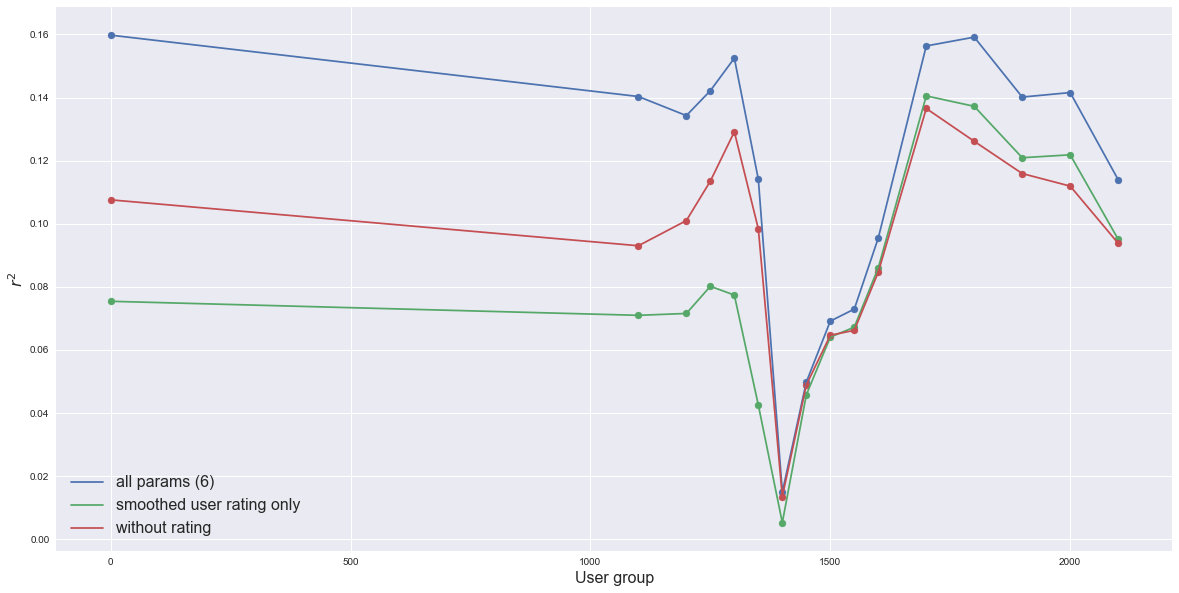

In [208]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

plt.plot   (lows, contr_all)
plt.scatter(lows, contr_all)
plt.plot   (lows, contr_rating)
plt.scatter(lows, contr_rating)
plt.plot   (lows, contr_norating)
plt.scatter(lows, contr_norating)

plt.ylabel('$r^2$', fontsize=16)
plt.xlabel('User group', fontsize=16)
plt.legend(['all params (6)', 'smoothed user rating only', 'without rating'], fontsize=16)


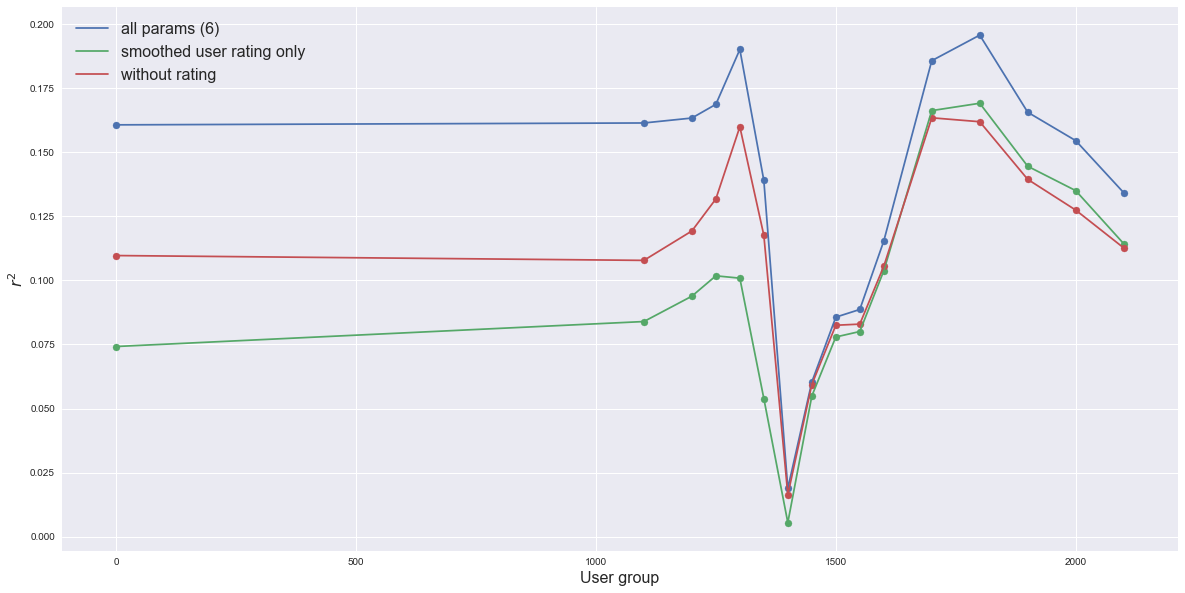

In [202]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

plt.plot   (lows, contr_all)
plt.scatter(lows, contr_all)
plt.plot   (lows, contr_rating)
plt.scatter(lows, contr_rating)
plt.plot   (lows, contr_norating)
plt.scatter(lows, contr_norating)

plt.ylabel('$r^2$', fontsize=16)
plt.xlabel('User group', fontsize=16)
plt.legend(['all params (6)', 'smoothed user rating only', 'without rating'], fontsize=16)

# Look ahead bias?

In [220]:
dfm['prev'] = np.roll(dfm['delta_smoothed_%dmonths' % month], 1)
Y = dfm['delta_smoothed_%dmonths'%month]

In [230]:
lows = [0   , 1100, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1700, 1800, 1900, 2000, 2100]
highs= [1100, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1700, 1800, 1900, 2000, 2100, 2500]
cols = ['rating_diff_mean', 'n_harder', 'n_wrong_mean', 'rating_diff_std', 'n_contest', 'smoothed_%dmonths'%month, 'prev']

contr_all = []
contr_rating = []
contr_norating = []
contr_lookbehind = []

colname = 'smoothed_%dmonths' % month

for low, high in zip(lows, highs):
    X = dfm.drop(['contesttime', 'contestid'], axis=1)

    # drop users who are tanking on purpose
    drop_users = set(['Hedgehogy', 'errorerror', 'Mhammad1', 'NelsonMondialu'])
    X.is_copy = False
    X.drop(X.index[X.handle.apply(lambda x: x in drop_users)], inplace=True)

    X = X.loc[np.logical_and(X[colname] >= low, X[colname] <= high)]

    # select features to use
    Y = X['delta_smoothed_%dmonths' % month]
    
    results_lookbehind = sm.OLS(Y.values, X['prev']).fit()
    X = X[cols]

    results_rating_only = sm.OLS(Y.values, X[colname]).fit()
    results = sm.OLS(Y.values, X).fit()
    X.drop(colname, inplace=True, axis=1)
    results_norating = sm.OLS(Y.values, X).fit()
    
    contr_all.append(results.rsquared)
    contr_rating.append(results_rating_only.rsquared)
    contr_norating.append(results_norating.rsquared)
    contr_lookbehind.append(results_lookbehind.rsquared)

    print "(%4d, %4d), %6d entries, ---------------> %f, %f" %(low, high, X.shape[0], results.rsquared, results_rating_only.rsquared)

(   0, 1100),  22887 entries, ---------------> 0.209262, 0.075433
(1100, 1200),  32674 entries, ---------------> 0.215735, 0.070988
(1200, 1250),  27716 entries, ---------------> 0.236668, 0.071580
(1250, 1300),  39502 entries, ---------------> 0.264887, 0.080185
(1300, 1350),  51705 entries, ---------------> 0.234794, 0.077409
(1350, 1400),  58000 entries, ---------------> 0.146309, 0.042550
(1400, 1450),  54114 entries, ---------------> 0.042279, 0.005298
(1450, 1500),  50805 entries, ---------------> 0.075003, 0.045797
(1500, 1550),  49670 entries, ---------------> 0.094419, 0.064085
(1550, 1600),  47311 entries, ---------------> 0.095843, 0.067239
(1600, 1700),  74872 entries, ---------------> 0.115084, 0.086056
(1700, 1800),  40939 entries, ---------------> 0.178362, 0.140529
(1800, 1900),  26122 entries, ---------------> 0.189521, 0.137217
(1900, 2000),  18228 entries, ---------------> 0.169251, 0.120933
(2000, 2100),  11870 entries, ---------------> 0.174879, 0.121853
(2100, 250

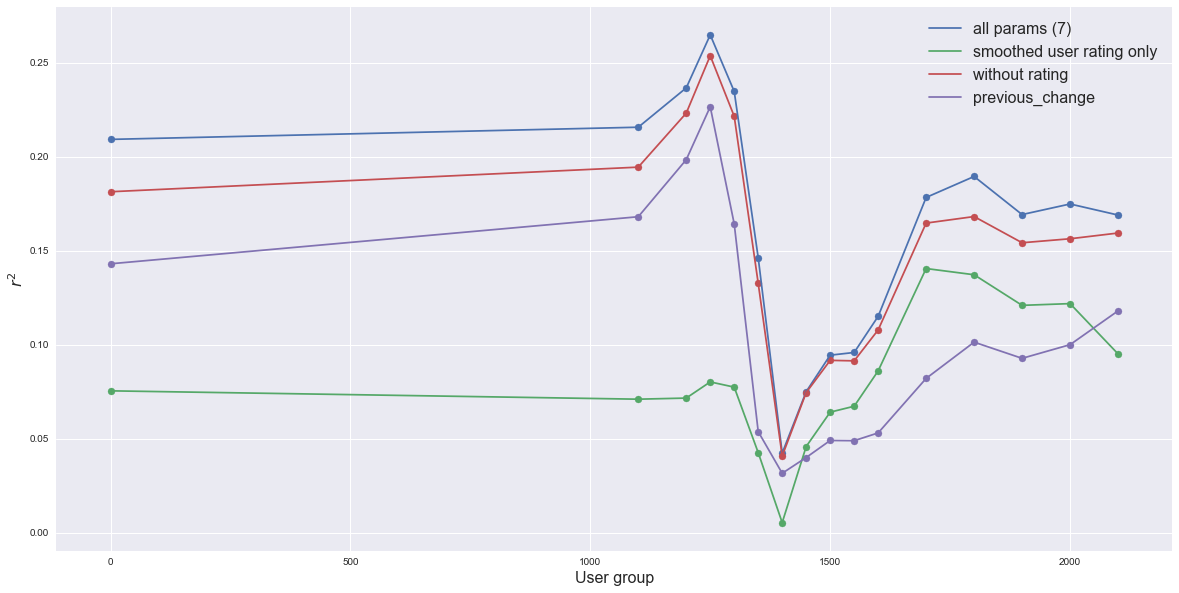

In [232]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

plt.plot   (lows, contr_all)
plt.scatter(lows, contr_all)
plt.plot   (lows, contr_rating)
plt.scatter(lows, contr_rating)
plt.plot   (lows, contr_norating)
plt.scatter(lows, contr_norating)
plt.plot   (lows, contr_lookbehind)
plt.scatter(lows, contr_lookbehind)

plt.ylabel('$r^2$', fontsize=16)
plt.xlabel('User group', fontsize=16)
plt.legend(['all params (7)', 'smoothed user rating only', 'without rating', 'previous_change'], fontsize=16)

In [223]:
test = sm.OLS(Y, dfm['prev']).fit()
print test.summary()

                              OLS Regression Results                              
Dep. Variable:     delta_smoothed_3months   R-squared:                       0.091
Model:                                OLS   Adj. R-squared:                  0.091
Method:                     Least Squares   F-statistic:                 6.303e+04
Date:                    Wed, 07 Jun 2017   Prob (F-statistic):               0.00
Time:                            16:37:38   Log-Likelihood:            -3.0163e+06
No. Observations:                  627996   AIC:                         6.033e+06
Df Residuals:                      627995   BIC:                         6.033e+06
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
prev        

In [133]:
from tensorflow.contrib import keras